In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Plant_leaf_disease_a1.zip" /content/

In [ ]:
!unzip /content/drive/MyDrive/Plant_leaf_disease_a1.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG 

In [ ]:
import os
print(os.listdir('/content/dataset/'))

['Plant_leave_diseases_dataset_with_augmentation1']


In [ ]:
dataset_dir = '/content/dataset/Plant_leave_diseases_dataset_with_augmentation1'

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder(dataset_dir, transform=transform)

# Split Dataset (Train: 70%, Validation: 15%, Test: 15%)
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))  # 85% for training + validation
validation_split = int(np.floor(0.70 * split))  # 70% of split for training

np.random.shuffle(indices)

train_indices, validation_indices, test_indices = (
    indices[:validation_split],
    indices[validation_split:split],
    indices[split:],
)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: /content/dataset/Plant_leave_diseases_dataset_with_augmentation1
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
               ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.2, 0.2))
               RandomPerspective(p=0.5)
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
model = models.mobilenet_v2(pretrained=True)

# Modify the last layer with Dropout
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Dropout to prevent overfitting
    nn.Linear(num_features, len(dataset.classes))
)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 217MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler (Reduce LR on Plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, validation_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []  # Store accuracies for each epoch

    for epoch in range(epochs):
        start_time = time.time()  # Track the start time for the epoch

        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                # Calculate validation accuracy
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == targets).sum().item()
                total_val += targets.size(0)

        val_loss /= len(validation_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        # Calculate time taken for this epoch
        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}% | "
              f"Validation Loss: {val_loss:.3f} | Validation Accuracy: {val_accuracy:.2f}% | "
              f"Time: {epoch_time:.2f} seconds")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, validation_loader, epochs=10)

Epoch 1/10 | Train Loss: 0.959 | Train Accuracy: 71.09% | Validation Loss: 0.768 | Validation Accuracy: 76.75% | Time: 826.16 seconds
Epoch 2/10 | Train Loss: 0.540 | Train Accuracy: 82.89% | Validation Loss: 0.473 | Validation Accuracy: 85.09% | Time: 811.64 seconds
Epoch 3/10 | Train Loss: 0.459 | Train Accuracy: 85.58% | Validation Loss: 0.357 | Validation Accuracy: 88.94% | Time: 829.85 seconds
Epoch 4/10 | Train Loss: 0.407 | Train Accuracy: 87.18% | Validation Loss: 0.379 | Validation Accuracy: 87.85% | Time: 808.93 seconds
Epoch 5/10 | Train Loss: 0.379 | Train Accuracy: 88.12% | Validation Loss: 0.374 | Validation Accuracy: 88.42% | Time: 800.98 seconds
Epoch 6/10 | Train Loss: 0.362 | Train Accuracy: 88.61% | Validation Loss: 0.344 | Validation Accuracy: 89.28% | Time: 801.85 seconds
Epoch 7/10 | Train Loss: 0.351 | Train Accuracy: 88.95% | Validation Loss: 0.310 | Validation Accuracy: 90.13% | Time: 802.18 seconds
Epoch 8/10 | Train Loss: 0.336 | Train Accuracy: 89.47% | Vali

In [ ]:
def evaluate_accuracy(loader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

# Get and Print Test Accuracy
test_accuracy = evaluate_accuracy(test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Print Final Train and Validation Accuracy
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

Test Accuracy: 91.33%
Final Train Accuracy: 90.00%
Final Validation Accuracy: 90.69%


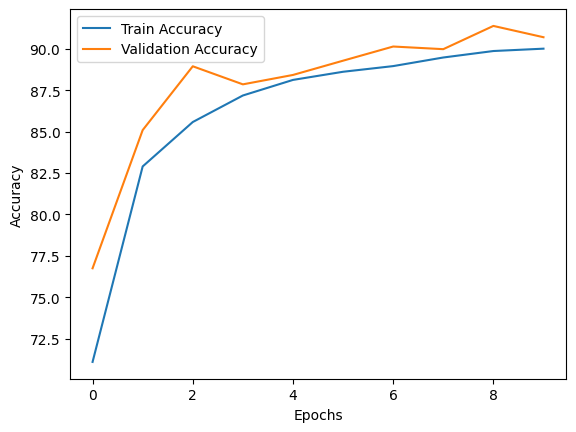

In [ ]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

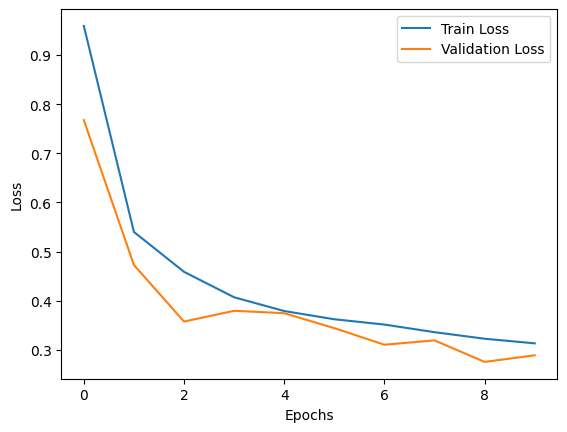

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def evaluate_model(loader):
    y_true, y_pred = [], []
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
y_true, y_pred = evaluate_model(test_loader)

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))

Classification Report:
                                                precision    recall  f1-score   support

                           Apple___Apple_scab       0.86      0.90      0.88       151
                            Apple___Black_rot       0.99      0.82      0.90       162
                     Apple___Cedar_apple_rust       0.99      0.96      0.98       165
                              Apple___healthy       0.95      0.86      0.90       260
                    Background_without_leaves       0.91      0.98      0.94       161
                          Blueberry___healthy       0.85      0.99      0.91       232
                      Cherry___Powdery_mildew       0.89      0.96      0.92       146
                             Cherry___healthy       0.92      0.96      0.94       160
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.84      0.89      0.86       149
                           Corn___Common_rust       0.99      0.85      0.92       165
                  

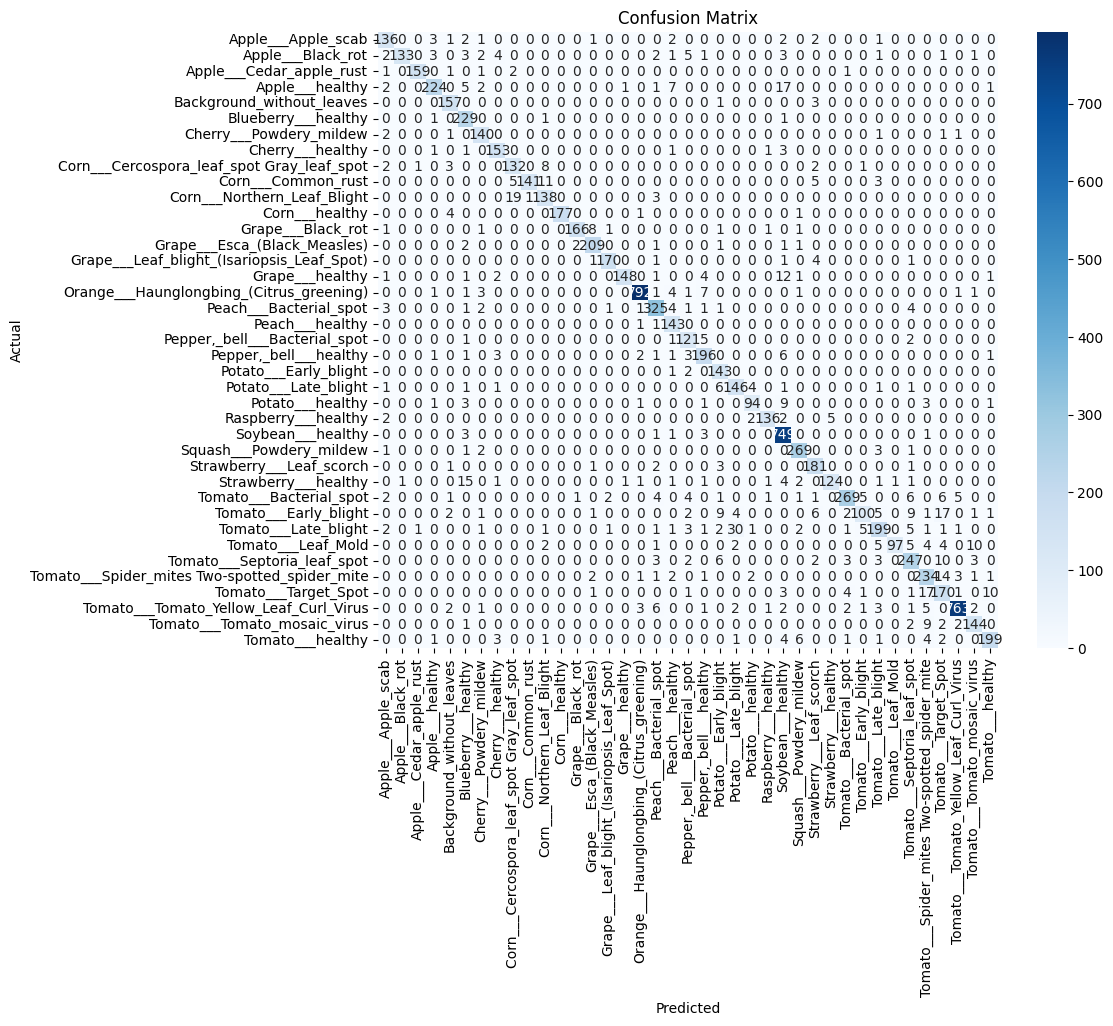

In [ ]:
plot_confusion_matrix(y_true, y_pred, dataset.classes)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate Metrics
test_accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

# Print Metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Test Accuracy: 0.9165
F1 Score: 0.9160
Precision: 0.9198
Recall: 0.9165


In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
import pandas as pd
from PIL import Image
import torchvision.transforms.functional as TF

In [ ]:
disease_info = pd.read_csv("/content/disease_info.csv", encoding="cp1252")
supplement_info = pd.read_csv("/content/supplement_info.csv", encoding="cp1252")

In [ ]:
transform_index_to_disease = dataset.class_to_idx
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)

In [ ]:
def single_detection(image_path):
    # Open and preprocess the image
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize to the input size for MobileNetV2
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))  # Adjust the shape for model input

    # Predict the disease
    output = model(input_data.to(device))
    output = output.detach().cpu().numpy()  # Get the output as numpy array
    index = np.argmax(output)  # Get the index of the predicted class

    # Get the predicted disease name from the CSV based on the index
    pred_csv = disease_info["disease_name"][index]

    # Extract the original image name from the image path
    original_name = image_path.split("/")[-1].split(".")[0]

    # Print the original name and the predicted disease
    print(f"Original: {original_name}")
    print(f"Detected Disease: {pred_csv}")

In [ ]:
single_detection("/content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Apple___Apple_scab/image (10).JPG")

Original: image (10)
Detected Disease: Cherry : Healthy


In [ ]:
single_detection("/content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Apple___Apple_scab/image (100).JPG")

Original: image (100)
Detected Disease: Cherry : Healthy


In [ ]:
single_detection("/content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Cherry___Powdery_mildew/image (1008).JPG")

Original: image (1008)
Detected Disease: Cherry : Powdery Mildew


In [ ]:
single_detection("/content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Cherry___Powdery_mildew/image (1022).JPG")

Original: image (1022)
Detected Disease: Cherry : Powdery Mildew


In [ ]:
single_detection("/content/dataset/Plant_leave_diseases_dataset_with_augmentation1/Grape___Black_rot/image (1005).JPG")

Original: image (1005)
Detected Disease: Grape : Black Rot


In [ ]:
print(disease_info['disease_name'].unique())  # See actual names in CSV

['Apple : Scab' 'Apple : Black Rot' 'Apple : Cedar rust' 'Apple : Healthy'
 'Background Without Leaves' 'Blueberry : Healthy'
 'Cherry : Powdery Mildew' 'Cherry : Healthy'
 'Corn : Cercospora Leaf Spot | Gray Leaf Spot' 'Corn : Common Rust'
 'Corn : Northern Leaf Blight' 'Corn : Healthy' 'Grape : Black Rot'
 'Grape : Esca | Black Measles'
 'Grape : Leaf Blight | Isariopsis Leaf Spot' 'Grape : Healthy'
 'Orange : Haunglongbing | Citrus Greening' 'Peach : Bacterial Spot'
 'Peach : Healthy' 'Pepper bell : Bacterial Spot' 'Pepper bell : Healthy'
 'Potato : Early Blight' 'Potato : Late Blight' 'Potato : Healthy'
 'Raspberry : Healthy' 'Soybean : Healthy' 'Squash : Powdery Mildew'
 'Strawberry : Leaf Scorch' 'Strawberry : Healthy'
 'Tomato : Bacterial Spot' 'Tomato : Early Blight' 'Tomato : Late Blight'
 'Tomato : Leaf Mold' 'Tomato : Septoria Leaf Spot'
 'Tomato : Spider Mites | Two-Spotted Spider Mite' 'Tomato : Target Spot'
 'Tomato : Yellow Leaf Curl Virus' 'Tomato : Mosaic Virus'
 'Toma

In [ ]:
print("Dataset Classes:", dataset.classes)
print("Disease Info CSV Classes:", disease_info['disease_name'].unique())

Dataset Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato

In [ ]:
torch.save(model.state_dict(), "plant_disease_model_1_latest.pt")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from google.colab import files
files.download("plant_disease_model_1_latest.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>